# Neural Style Transfer Algorithms modifications
MIPT DLS Homework, Jan 2020

Alla Chepurova


In [ ]:
!pip3 install torch torchvision
!pip3 install pillow==4.1.1

In [1]:
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim



import torchvision.transforms as transforms
import torchvision.models as models

import copy

## 1. Two styles at the same image
First modification I decided to implement - applying two styles at the same time to one content images. 

Source paper for my implementation - http://cs231n.stanford.edu/reports/2017/pdfs/401.pdf .

I have modificated style loss function in such a way that two losses are blended with each other; the coefficient for every style in my implementation is the weighted mean as it is proposed in the above paper.

Classes for different types of losses - for content and style.

Also class for image normalization to use VGG successfully and function for finding Gram matrix, which is used for finding style loss.

In [2]:
class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()
            self.mean = torch.tensor(mean).view(-1, 1, 1)
            self.std = torch.tensor(std).view(-1, 1, 1)

        def forward(self, img):
            return (img - self.mean) / self.std

def gram_matrix(input):
        batch_size , h, w, f_map_num = input.size()
        features = input.view(batch_size * h, w * f_map_num)
        G = torch.mm(features, features.t())
        return G.div(batch_size * h * w * f_map_num)

class ContentLoss(nn.Module):
        def __init__(self, target):
            super(ContentLoss, self).__init__()
            self.target = target.detach()
            self.loss = F.mse_loss(self.target, self.target)

        def forward(self, input):
            self.loss = F.mse_loss(input, self.target)
            return input

class StyleLoss(nn.Module):
        def __init__(self, target_feature):
            super(StyleLoss, self).__init__()
            self.target = []
            for i in range(len(target_feature)):
              self.target.append(gram_matrix(target_feature[i]).detach())
            self.loss = F.mse_loss(self.target[i], self.target[i])

        def forward(self, input):
            G = gram_matrix(input)
            losses = [F.mse_loss(G, self.target[i]) for i in range(len(self.target))]
            coef = sum(losses)
            self.loss = sum([l*l/coef for l in losses])
            return input
    

I decided to wrap up all functionality for style transfering process in one class so that it would be more convinient to use with different CNNs, trying out different layers to form style and content losses and reusing results that I already achieved.

And one more detail - I impelemented more functionality that was proposed in the task to make my class more general for usage. I added ability to transfer >=1 style with no limitations. So, technically, to add even more than two styles you just need to pass an array with needed style images with lenght >=1 (but would it matter to add more than 3 at all?).

In [3]:
class StyleTransferer():
  def __init__(self, content_layers, style_layers, cnn, device):
    self.content_layers = content_layers
    self.style_layers = style_layers
    self.cnn = cnn
    self.cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
    self.cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
    self.device = device

  def prepare_model(self, style_img, content_img):
    cnn = copy.deepcopy(self.cnn)
    normalization = Normalization(self.cnn_normalization_mean, self.cnn_normalization_std).to(self.device)
    self.input_img = content_img.clone()


    self.content_losses = []
    self.style_losses = []

    self.model = nn.Sequential(normalization)

    i = 0  # counting convolution layers
    j = 1  # counting pooling layers
    for layer in cnn.children():

        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv{}-{}'.format(j, i)

        elif isinstance(layer, nn.ReLU):
            name = 'relu{}-{}'.format(j, i)
            layer = nn.ReLU(inplace=False)

        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool-{}'.format(j)
            j += 1
            i = 0

        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn{}-{}'.format(j, i)
        else:
            raise RuntimeError('Not a standart layer found: {}'.format(layer.__class__.__name__))

        self.model.add_module(name, layer)

        if name in self.content_layers:
  
            target = self.model(content_img).detach()
            content_loss = ContentLoss(target)
            self.model.add_module("content_loss_{}-{}".format(j, i), content_loss)
            self.content_losses.append(content_loss)

        if name in self.style_layers:
            
            target_feature = []
            for si in style_img:
                target_feature.append(self.model(si).detach())
            style_loss = StyleLoss(target_feature)
            self.model.add_module("style_loss_{}-{}".format(j, i), style_loss)
            self.style_losses.append(style_loss)

    
    for i in range(len(self.model) - 1, -1, -1):
        if isinstance(self.model[i], ContentLoss) or isinstance(self.model[i], StyleLoss):
            break

    self.model = self.model[:(i + 1)]


  def transfer(self, content_img, style_img, num_steps=500,
                          style_weight=10000, content_weight=1):
    
    self.prepare_model(style_img, content_img)
    
    optimizer = optim.LBFGS([self.input_img.requires_grad_()]) 

    iter = 0
    while iter <= num_steps:

        def closure():

            self.input_img.data.clamp_(0, 1)

            optimizer.zero_grad()

            self.model(self.input_img)

            style_score = 0
            content_score = 0

            for sl in self.style_losses:
                style_score += sl.loss
            for cl in self.content_losses:
                content_score += cl.loss
            
            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            return style_score + content_score

        iter += 1
        if iter % 100 == 0:
          print("Iteration {}".format(iter))
              

          optimizer.step(closure)

   
    self.input_img.data.clamp_(0, 1)

    return self.input_img

Parameters for our first transferer object and object initializing

In [4]:
content_layers = ['conv1-1', 'conv2-1', 'conv3-1', 'conv4-1', 'conv5-1']
style_layers = ['conv1-1', 'conv2-1', 'conv3-1', 'conv4-1', 'conv5-1']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cnn = models.vgg16(pretrained=True).features.to(device).eval()

transfer = StyleTransferer(content_layers, style_layers, cnn, device)

Pics that I would like to use and their transforms to tensor with convinient format.

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def image_loader(image_name, imsize):
    loader = transforms.Compose([
    transforms.Resize(imsize), 
    transforms.CenterCrop(imsize),
    transforms.ToTensor()])

    image = Image.open(image_name).convert('RGB')
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


content_img = image_loader("cat.jpg", 128)
style_img = image_loader("pikasso.jpg", 128)
style_img2 = image_loader("Matiss.jpg", 128)
style_img3 = image_loader("gog2.jpg", 128)
style_img4 = image_loader("wave.jpg", 128)
mask = image_loader('mask.jpg', 128)

Function for plotting pictures from tensors


In [6]:
unloader = transforms.ToPILImage()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)      
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

First try with our experiment

In [7]:
style_arr = [style_img, style_img2]
output = transfer.transfer(content_img, style_arr, num_steps=500,
                          style_weight=10000, content_weight=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500


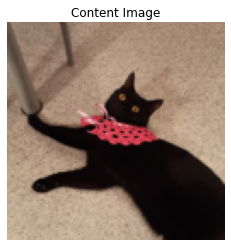

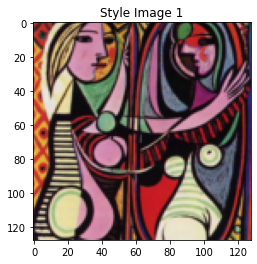

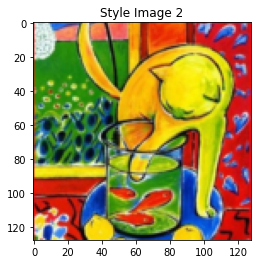

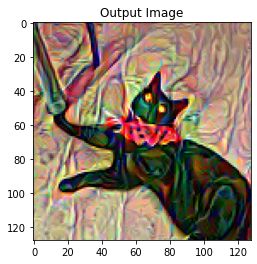

In [8]:
plt.figure()
plt.axis("off") 
imshow(content_img, title='Сontent Image')
imshow(style_img, title='Style Image 1')
imshow(style_img2, title='Style Image 2')
imshow(output, title='Output Image')
plt.ioff()
plt.show()

Second try with different styles,

Hope you still enjoy this:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500


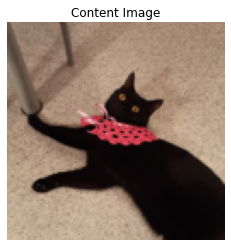

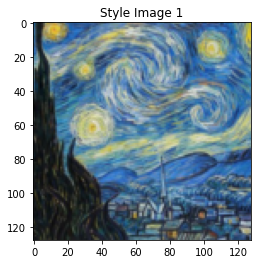

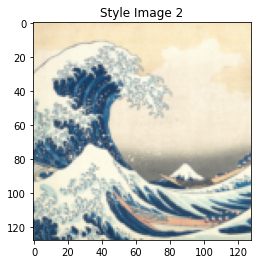

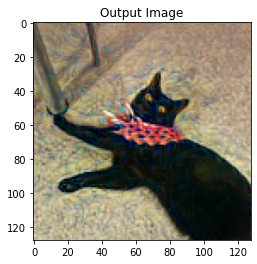

In [9]:
style_arr = [style_img3, style_img4]
output = transfer.transfer(content_img, style_arr, num_steps=500,
                          style_weight=10000, content_weight=1)

plt.figure()
plt.axis("off") 
imshow(content_img, title='Content Image')
imshow(style_img3, title='Style Image 1')
imshow(style_img4, title='Style Image 2')
imshow(output, title='Output Image')
plt.ioff()
plt.show()

## 2. Two styles at the same image, but divided by areas
The second modification - applying two styles at the different areas on one image. 

Source paper that idea from which I used in the following implementation - http://cs231n.stanford.edu/reports/2017/pdfs/416.pdf .


I apply binary mask to input images in forward path within Style loss right before it goes to the gram_matrix() function. This mask has corresponding size of layer in wich it enters and the form of needed area on the resulting pic. So that I can trace the loss only in one area of the pic. For using second style image I just added second mask which is inverted version of the first one I mentioned.

One techincal detail - I just rewrite StyleLoss() function for new implementation and make MaskStyleTransferer class inheriting StyleTransferer one that I wrote before, so in this case I just needed to override functions with new features and it automatically reuses the code in parent, which I found very handful.

In [10]:
class StyleLoss(nn.Module):
        def __init__(self, target_feature1, target_feature2, mask):
            super(StyleLoss, self).__init__()

            self.mask = mask.detach()
            self.inverted_mask = abs(mask-1).detach()
            self.target1 = gram_matrix(target_feature1.detach())
            self.target2 = gram_matrix(target_feature2.detach())
            self.loss = F.mse_loss(self.target1, self.target1)

        def forward(self, input):
          mask = self.mask
          inverted_mask = self.inverted_mask
          loader = transforms.Compose([
            transforms.Resize(input.size()[2])])
          
          mask = loader(mask)[0][0]
          inverted_mask = loader(inverted_mask)[0][0]

          mask = torch.stack([mask for i in range(input.size()[1])], dim=0).unsqueeze(0)
          inverted_mask = torch.stack([inverted_mask for i in range(input.size()[1])], dim=0).unsqueeze(0)

          G1 = gram_matrix(input * mask)
          G2 = gram_matrix(input * inverted_mask)
          self.loss = (F.mse_loss(G1, self.target1) + F.mse_loss(G2, self.target2)) / 2
          return input

class MaskStyleTransferer(StyleTransferer):
  def __init__(self, content_layers, style_layers, mask, cnn, device):
    self.content_layers = content_layers
    self.style_layers = style_layers
    self.cnn = cnn
    self.cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
    self.cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
    self.device = device
    self.mask = mask 

  def prepare_model(self, style_img, content_img):
    cnn = copy.deepcopy(self.cnn)
    normalization = Normalization(self.cnn_normalization_mean, self.cnn_normalization_std).to(self.device)
    self.content_losses = []
    self.style_losses = []
    self.input_img = content_img.clone()

    self.model = nn.Sequential(normalization)

    i = 0  # counting convolution layers
    j = 1  # counting pooling layers
    for layer in cnn.children():

        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv{}-{}'.format(j, i)

        elif isinstance(layer, nn.ReLU):
            name = 'relu{}-{}'.format(j, i)
            layer = nn.ReLU(inplace=False)

        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool-{}'.format(j)
            j += 1
            i = 0

        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn{}-{}'.format(j, i)
        else:
            raise RuntimeError('Not a standart layer found: {}'.format(layer.__class__.__name__))

        self.model.add_module(name, layer)

        if name in self.content_layers:
  
            target = self.model(content_img).detach()
            content_loss = ContentLoss(target)
            self.model.add_module("content_loss_{}-{}".format(j, i), content_loss)
            self.content_losses.append(content_loss)

        if name in self.style_layers:
            target_feature1 = self.model(style_img[0]).detach()
            target_feature2 = self.model(style_img[1]).detach()
            style_loss = StyleLoss(target_feature1, target_feature2, self.mask)
            self.model.add_module("style_loss_{}-{}".format(j, i), style_loss)
            self.style_losses.append(style_loss)

    
    for i in range(len(self.model) - 1, -1, -1):
        if isinstance(self.model[i], ContentLoss) or isinstance(self.model[i], StyleLoss):
            break

    self.model = self.model[:(i + 1)]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500


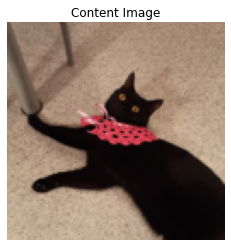

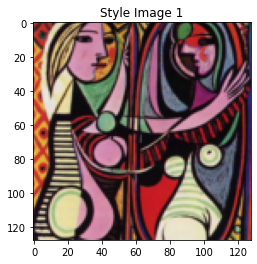

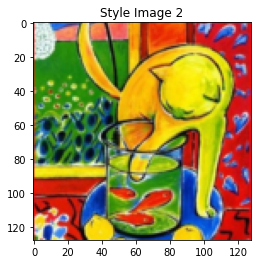

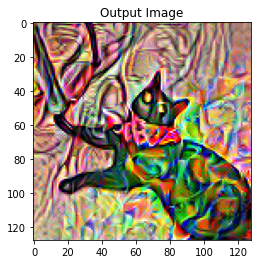

In [11]:
input_img = torch.randn(content_img.data.size(), device=device)

transfer = MaskStyleTransferer(content_layers, style_layers, mask, cnn, device)
style_arr = [style_img, style_img2]
output = transfer.transfer(content_img, style_arr, num_steps=500,
                          style_weight=10000, content_weight=1)

plt.figure()
plt.axis("off") 
imshow(content_img, title='Content Image')
imshow(style_img, title='Style Image 1')
imshow(style_img2, title='Style Image 2')
imshow(output, title='Output Image')

Two more entrance with pics :)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500


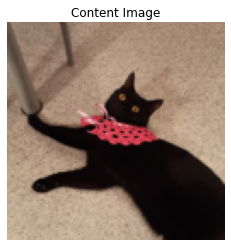

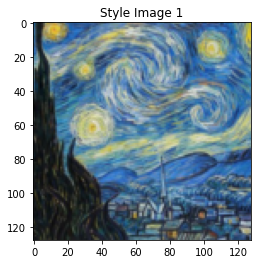

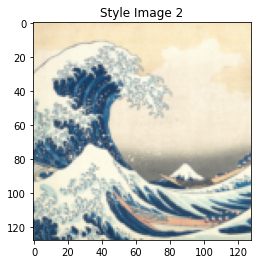

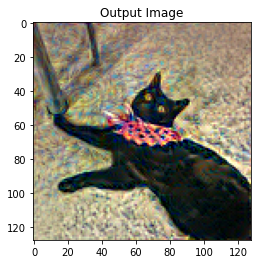

In [12]:
style_arr = [style_img3, style_img4]
output = transfer.transfer(content_img, style_arr, num_steps=500,
                          style_weight=10000, content_weight=1)

plt.figure()
plt.axis("off") 
imshow(content_img, title='Content Image')
imshow(style_img3, title='Style Image 1')
imshow(style_img4, title='Style Image 2')
imshow(output, title='Output Image')
plt.ioff()
plt.show()

## Thank you for your attention :)